<a href="https://colab.research.google.com/github/danielka223/ds_workshop/blob/master/dsWorkshopAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="left">Helpfulness Prediction of Amazon Product Reviews</h1> 
<h2 align="left">DS Workshop - Fall 18/19 - Tel Aviv University</h2> 
<h3 align="left">By Daniel K.A, Ido Salomon, Itamar Mutzafi and Sagi Aharoni</h3> 




#Notebook Initialization
This section should only run once on a new runtime

In [0]:
#@title Install Required Packages

!pip install wordcloud

In [0]:
#@title Import Python Libraries {display-mode: "form"}

import os
import glob
import pandas as pd
import json
import datetime

from google.colab import drive

from contextlib import contextmanager
from os.path import getsize, basename
from tqdm import tqdm

import requests
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import gzip

In [3]:
#@title Connect to Drive {display-mode: "form"}

drive.mount('/content/drive/')
            

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#@title Infra Definitions

@contextmanager
def pbopen(filename, mode='r'):
    total = getsize(filename)
    pb = tqdm(total=total, unit="B", unit_scale=True,
              desc=basename(filename), miniters=1,
              ncols=80, ascii=True)

    def wrapped_line_iterator(fd):
        processed_bytes = 0
        for line in fd:
            processed_bytes += len(line)
            # update progress every MB.
            if processed_bytes >= 1024 * 1024:
                pb.update(processed_bytes)
                processed_bytes = 0

            yield line

        # finally
        pb.update(processed_bytes)
        pb.close()

    with open(filename, mode) as fd:
        yield wrapped_line_iterator(fd)
        
#decompress input folder to output folder
def ungzip(source_dir, dest_dir):
  for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
      base = os.path.basename(src_name)
      dest_name = os.path.join(dest_dir, base[:-3])
      with gzip.open(src_name, 'rb') as infile:
          with open(dest_name, 'wb') as outfile:
              for line in infile:
                  outfile.write(line)

In [0]:
#@title Data Fetching

# the following script downloads the Amazon Review Dataset into google drive

root = "drive/Team Drives/DS Workshop/data/"
compressed_path = root + "compressed/"

#uncomment to download
review_paths = [
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_DVD_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Tools_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Sports_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_PC_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Outdoors_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Music_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Major_Appliances_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Luggage_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Lawn_and_Garden_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Jewelry_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Improvement_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Health_Personal_Care_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_01.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Baby_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz",
               ]

#download dataset for each category, store in drive
for url in review_paths:
  print("starded downloading " + url)
  category = re.search('us_(.+?)_v1', url).group(1)
  file_path = compressed_path + category + ".tsv.gz"
  r = requests.get(url, allow_redirects=True)
  open(file_path, 'wb').write(r.content)
  print("finished downloading " + url)

#unzip datasets  
#ungzip(compressed_path, root)

# Data Collection and Integration


In [0]:
#@title Data Filters

include_all_categories = False #@param {type:"boolean"}
correct_bias = False #@param {type:"boolean"}
pick_category = "Video_Games"  #@param ['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Books_v1_00', 'Books_v1_01', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Ebook_Purchase1', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']
entry_limit = 150000  #@param {type: "slider", min: 1000, max: 5000000, step:1000}
#@markdown ---
#@markdown ###Review Filters
filter_reviews_older_than = '2010-11-05'  #@param {type: "date"}

#generate ds paths
root = "drive/Team Drives/DS Workshop/data/"
file_ext = ".tsv"
ds_path = root + pick_category + file_ext

file_names = glob.glob1(root, "*" + file_ext)
all_paths = [root + filename for filename in file_names]

In [0]:
if include_all_categories:
  ds_list = []
  for path in all_paths:
    cat_ds = pd.read_csv(path, 
                        delimiter='\t',
                        warn_bad_lines=True,
                        error_bad_lines=False,
                        nrows=entry_limit)
    ds_list.append(cat_ds)
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
else:
  reviews = pd.read_csv(ds_path, 
                        delimiter='\t',
                        warn_bad_lines=True,
                        error_bad_lines=False,
                        nrows=entry_limit)

reviews['unhelpful_votes'] = reviews['total_votes'] - reviews['helpful_votes']

# add helpful column. A review is considered helpful if it was upvoted at least once
reviews['helpful'] = reviews['helpful_votes'] > 0

thumbs = pd.DataFrame(reviews.groupby('customer_id').mean())
thumbs = thumbs[['helpful_votes','unhelpful_votes']]
thumbs.columns = ['helpful_votes_avg','helpful_votes_avg']
commentCount=pd.DataFrame(reviews.groupby('customer_id').size())
commentCount.columns=['commentCount']
reviews = reviews.join(commentCount, on='customer_id').join(thumbs, on='customer_id')
reviews.describe()
reviews.head()

# reviews.count()

## Bias Correction

In [0]:
if correct_bias:
  df1 = reviews[reviews['helpful'] == True]
  df2 = reviews[reviews['helpful'] == False].sample(n=df1.count()[0])
  reviews = pd.concat([df1,df2])

#Data Preperation and Cleaning

#Data Visualization and Analysis

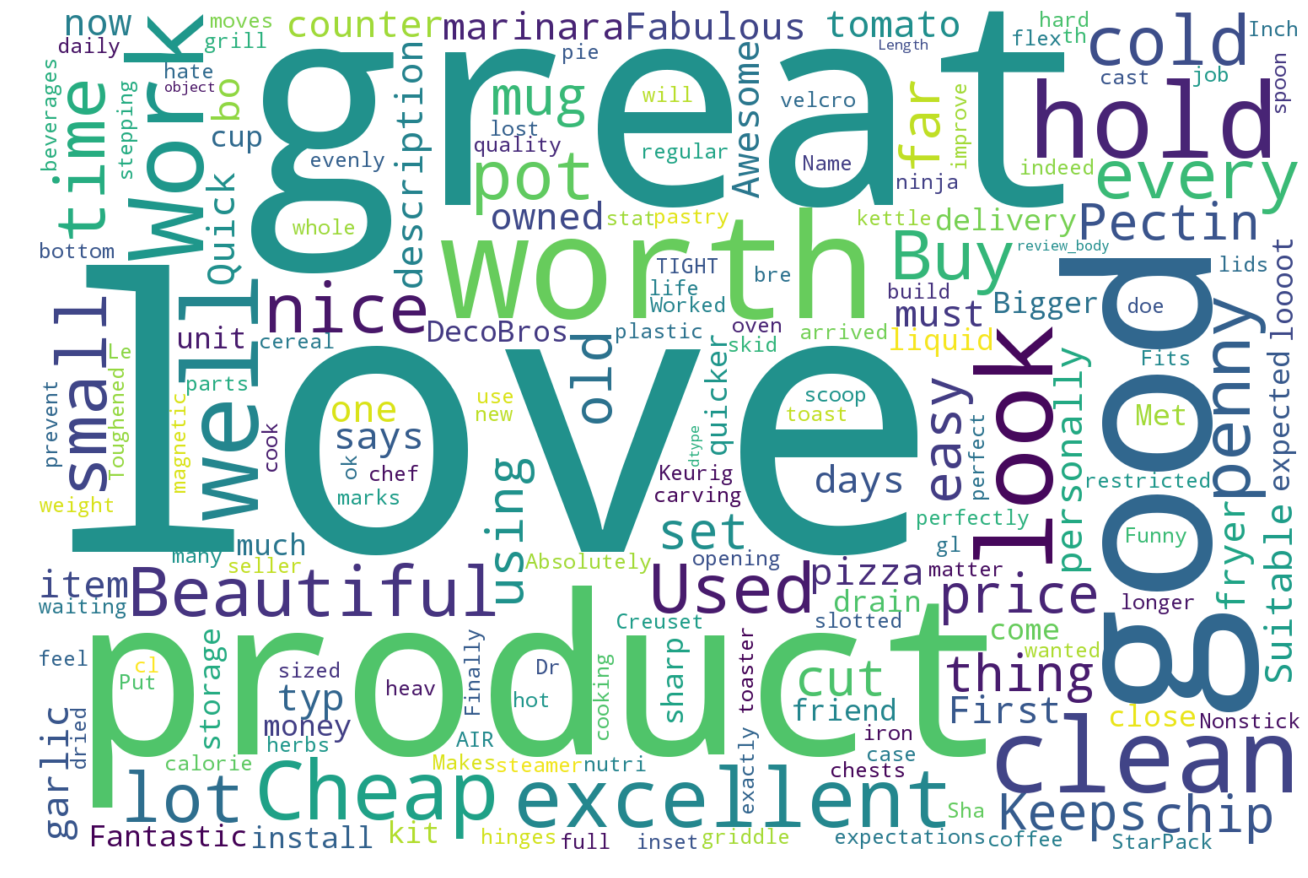

In [8]:
#wordcloud
text = reviews['review_body']
wordcloud = WordCloud(
    width = 1500,
    height = 1000,
    background_color = 'white',
    ).generate(str(text))
fig = plt.figure(
    figsize = (18, 12),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Feature Selection and Engineering

# Model Training

In [17]:
# CNN for the IMDB problem
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from keras.utils import np_utils
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

data = reviews
data = data.loc[:, ['review_body','helpful']]


#Convert reviews text to lowercase
data['text'] = data['review_body'].apply(lambda x: str(x).lower())
#Remove all charactares appart from a-zA-z0-9 (for instance: punctuation)
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

#overallDistribution = data.overall.value_counts().sort_index()
#print(overallDistribution)

#Vocabulary size - Most 2000 common words
#Convert input text to integer sequences
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
#cap the maximum review length at 500 words,
#truncating reviews longer than that and
# padding reviews shorter than that with 0 values.
max_review_length = 500
X = pad_sequences(X,  maxlen=max_review_length)

# Using embedding from Keras
embedding_vector_length = 32
def baseline_model():
    # create the model - Machine learning mastery
    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    # model.add(Dropout(0.1))
    model.add(Dense(250, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

Y = data['helpful']
# Fit the model
epochs_num = 2
batchSize = 128

model = KerasClassifier(build_fn=baseline_model, epochs=epochs_num, batch_size=batchSize, verbose=0)

nsplits = 3
kfold = KFold(n_splits=nsplits, shuffle=True, random_state=1)
results = cross_val_score(model, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 250)               2000250   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
_________________________________________________________________


# Model Evaluation